In [72]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import requests
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
import requests
import pandas as pd
from datetime import datetime

# 將民國日期轉為西元日期
def convert_tw_date(tw_date: str) -> str:
    y, m, d = map(int, tw_date.split('/'))
    return f"{y + 1911}-{m:02d}-{d:02d}"

# 抓取單月資料
def get_monthly_data(stock_no: str, year: int, month: int) -> pd.DataFrame:
    date = f"{year}{month:02d}01"
    url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY"
    params = {
        "response": "json",
        "date": date,
        "stockNo": stock_no
    }
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    res = requests.get(url, params=params, headers=headers)
    data = res.json()
    if data["stat"] != "OK":
        return pd.DataFrame()
    
    df = pd.DataFrame(data["data"], columns=data["fields"])
    df["日期"] = df["日期"].apply(convert_tw_date)
    df["日期"] = pd.to_datetime(df["日期"])
    return df

# 抓取多月資料並合併
def get_range_data(stock_no: str, start: str, end: str) -> pd.DataFrame:
    start_date = datetime.strptime(start, "%Y-%m-%d")
    end_date = datetime.strptime(end, "%Y-%m-%d")

    all_data = pd.DataFrame()
    current = start_date

    while current <= end_date:
        df = get_monthly_data(stock_no, current.year, current.month)
        all_data = pd.concat([all_data, df], ignore_index=True)
        # 移到下個月
        if current.month == 12:
            current = datetime(current.year + 1, 1, 1)
        else:
            current = datetime(current.year, current.month + 1, 1)

    # 篩選目標範圍
    mask = (all_data["日期"] >= pd.to_datetime(start)) & (all_data["日期"] <= pd.to_datetime(end))
    return all_data.loc[mask].reset_index(drop=True)

# === 執行範例 ===
if __name__ == "__main__":
    stock_no = "2722"
    start_date = "2023-01-01"
    end_date = "2025-03-31"

    stock_df = get_range_data(stock_no, start_date, end_date)
    stock_df.rename(columns={
    '日期': 'post_time',
    '成交股數': 'volume',
    '成交金額': 'amount',
    '開盤價': 'open',
    '最高價': 'high',
    '最低價': 'low',
    '收盤價': 'close',
    '漲跌價差': 'change',
    '成交筆數': 'transaction'
}, inplace=True)
    stock_df.to_csv(f"{stock_no}_TWSE_{start_date}_to_{end_date}.csv", index=False, encoding="utf-8-sig")

    print(f"成功匯出 {len(stock_df)} 筆資料至 CSV！")
    print(stock_df.head())


成功匯出 536 筆資料至 CSV！
   post_time   volume     amount   open   high    low  close change  \
0 2023-01-03  107,253  3,512,864  33.25  33.25  32.50  32.80  -0.60   
1 2023-01-04   95,435  3,110,800  33.00  33.35  32.25  32.40  -0.40   
2 2023-01-05   87,294  2,845,907  32.45  33.00  32.20  32.25  -0.15   
3 2023-01-06   60,015  1,927,481  32.25  32.45  32.00  32.10  -0.15   
4 2023-01-09   58,308  1,875,796  32.35  32.35  32.05  32.15  +0.05   

  transaction  
0         118  
1         103  
2         104  
3          57  
4          87  


In [ ]:
# stock_df.rename(columns={'日期': 'post_time'}, inplace=True)
# stock_df.rename(columns={'成交股數': 'volume'}, inplace=True)
# stock_df.rename(columns={'成交金額': 'amount'}, inplace=True)
# stock_df.rename(columns={'開盤價': 'open'}, inplace=True)
# stock_df.rename(columns={'最高價': 'high'}, inplace=True)
# stock_df.rename(columns={'最低價': 'low'}, inplace=True)
# stock_df.rename(columns={'收盤價': 'close'}, inplace=True)
# stock_df.rename(columns={'漲跌價差': 'change'}, inplace=True)
# stock_df.rename(columns={'成交筆數': 'transaction'}, inplace=True)

In [54]:
stock_df

,post_time,volume,amount,open,high,low,close,change,transaction
0,2023-01-03,"107,253","3,512,864",33.25,33.25,32.50,32.80,-0.60,118
1,2023-01-04,"95,435","3,110,800",33.00,33.35,32.25,32.40,-0.40,103
2,2023-01-05,"87,294","2,845,907",32.45,33.00,32.20,32.25,-0.15,104
3,2023-01-06,"60,015","1,927,481",32.25,32.45,32.00,32.10,-0.15,57
4,2023-01-09,"58,308","1,875,796",32.35,32.35,32.05,32.15,+0.05,87
...,...,...,...,...,...,...,...,...,...
531,2025-03-25,"80,281","2,509,545",31.40,31.60,31.00,31.00,-0.55,57
532,2025-03-26,"67,273","2,121,353",32.00,32.00,31.40,31.70,+0.70,48
533,2025-03-27,"40,552","1,270,052",31.50,31.50,31.15,31.20,-0.50,43
534,2025-03-28,"141,260","4,306,202",30.85,30.85,30.20,30.35,-0.85,109


In [55]:
stock_df['close'] = stock_df['close'].astype(float)

In [56]:
stock_df.loc[0, 'close']

32.8

In [57]:
for i in range(1, len(stock_df)):
    stock_df.at[i, "change"] = stock_df.loc[i, "close"] - stock_df.loc[i-1, "close"]
    stock_df.at[i, "return"] = stock_df.at[i, "change"] / stock_df.loc[i-1, "close"]
stock_df["change"] = stock_df["change"].astype(float)
stock_df["return"] = stock_df["return"].astype(float)
stock_df

,post_time,volume,amount,open,high,low,close,change,transaction,return
0,2023-01-03,"107,253","3,512,864",33.25,33.25,32.50,32.80,-0.60,118,NaN
1,2023-01-04,"95,435","3,110,800",33.00,33.35,32.25,32.40,-0.40,103,-0.012195
2,2023-01-05,"87,294","2,845,907",32.45,33.00,32.20,32.25,-0.15,104,-0.004630
3,2023-01-06,"60,015","1,927,481",32.25,32.45,32.00,32.10,-0.15,57,-0.004651
4,2023-01-09,"58,308","1,875,796",32.35,32.35,32.05,32.15,0.05,87,0.001558
...,...,...,...,...,...,...,...,...,...,...
531,2025-03-25,"80,281","2,509,545",31.40,31.60,31.00,31.00,-0.55,57,-0.017433
532,2025-03-26,"67,273","2,121,353",32.00,32.00,31.40,31.70,0.70,48,0.022581
533,2025-03-27,"40,552","1,270,052",31.50,31.50,31.15,31.20,-0.50,43,-0.015773
534,2025-03-28,"141,260","4,306,202",30.85,30.85,30.20,30.35,-0.85,109,-0.027244


In [61]:
stock_df['return'].fillna(0, inplace=True)

/var/folders/dp/v8nwqctd0rqfmk1cclf4q0w40000gn/T/ipykernel_19173/925586977.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stock_df['return'].fillna(0, inplace=True)


In [66]:
stock_df_mean = stock_df["return"].mean()
stock_df_std = stock_df["return"].std()

alpha = 0.05
z_score = norm.ppf(1 - alpha/2)
upper_bound = stock_df_mean + z_score*(stock_df_std / (len(stock_df['return'])**0.5))
lower_bound = stock_df_mean - z_score*(stock_df_std / (len(stock_df['return'])**0.5))
confidence_interval = (lower_bound, upper_bound)
confidence_interval

stock_df["BullBear"] = stock_df["return"].apply(lambda x: -1 if x<lower_bound else(1 if x>upper_bound else 0))

print(stock_df[["return", "BullBear"]].head(10))

stock_df['post_time'] = pd.to_datetime(stock_df['post_time'])
stock_df['previous_date'] = stock_df['post_time'].shift(1)
stock_df['previous_date_2'] = stock_df['post_time'] - pd.Timedelta(days = 1)
stock_df

     return  BullBear
0  0.000000         0
1 -0.012195        -1
2 -0.004630        -1
3 -0.004651        -1
4  0.001558         0
5  0.007776         1
6  0.003086         1
7  0.000000         0
8  0.003077         1
9 -0.001534         0


,post_time,volume,amount,open,high,low,close,change,transaction,return,BullBear,previous_date,previous_date_2
0,2023-01-03,"107,253","3,512,864",33.25,33.25,32.50,32.80,-0.60,118,0.000000,0,NaT,2023-01-02
1,2023-01-04,"95,435","3,110,800",33.00,33.35,32.25,32.40,-0.40,103,-0.012195,-1,2023-01-03,2023-01-03
2,2023-01-05,"87,294","2,845,907",32.45,33.00,32.20,32.25,-0.15,104,-0.004630,-1,2023-01-04,2023-01-04
3,2023-01-06,"60,015","1,927,481",32.25,32.45,32.00,32.10,-0.15,57,-0.004651,-1,2023-01-05,2023-01-05
4,2023-01-09,"58,308","1,875,796",32.35,32.35,32.05,32.15,0.05,87,0.001558,0,2023-01-06,2023-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,2025-03-25,"80,281","2,509,545",31.40,31.60,31.00,31.00,-0.55,57,-0.017433,-1,2025-03-24,2025-03-24
532,2025-03-26,"67,273","2,121,353",32.00,32.00,31.40,31.70,0.70,48,0.022581,1,2025-03-25,2025-03-25
533,2025-03-27,"40,552","1,270,052",31.50,31.50,31.15,31.20,-0.50,43,-0.015773,-1,2025-03-26,2025-03-26
534,2025-03-28,"141,260","4,306,202",30.85,30.85,30.20,30.35,-0.85,109,-0.027244,-1,2025-03-27,2025-03-27


In [69]:
Bull_data = stock_df[stock_df['BullBear'] == 1]
Bear_data = stock_df[stock_df['BullBear'] == -1]
Bull_data = Bull_data[['post_time', 'previous_date', 'previous_date_2', 'BullBear', 'return']]
Bear_data = Bear_data[['post_time', 'previous_date', 'previous_date_2', 'BullBear', 'return']]

In [106]:
Bull_data

,post_time,previous_date,previous_date_2,BullBear,return
5,2023-01-10,2023-01-09,2023-01-09,1,0.007776
6,2023-01-11,2023-01-10,2023-01-10,1,0.003086
8,2023-01-13,2023-01-12,2023-01-12,1,0.003077
10,2023-01-17,2023-01-16,2023-01-16,1,0.003072
12,2023-01-31,2023-01-30,2023-01-30,1,0.012289
...,...,...,...,...,...
508,2025-02-19,2025-02-18,2025-02-18,1,0.005714
517,2025-03-05,2025-03-04,2025-03-04,1,0.013216
526,2025-03-18,2025-03-17,2025-03-17,1,0.011290
528,2025-03-20,2025-03-19,2025-03-19,1,0.025600


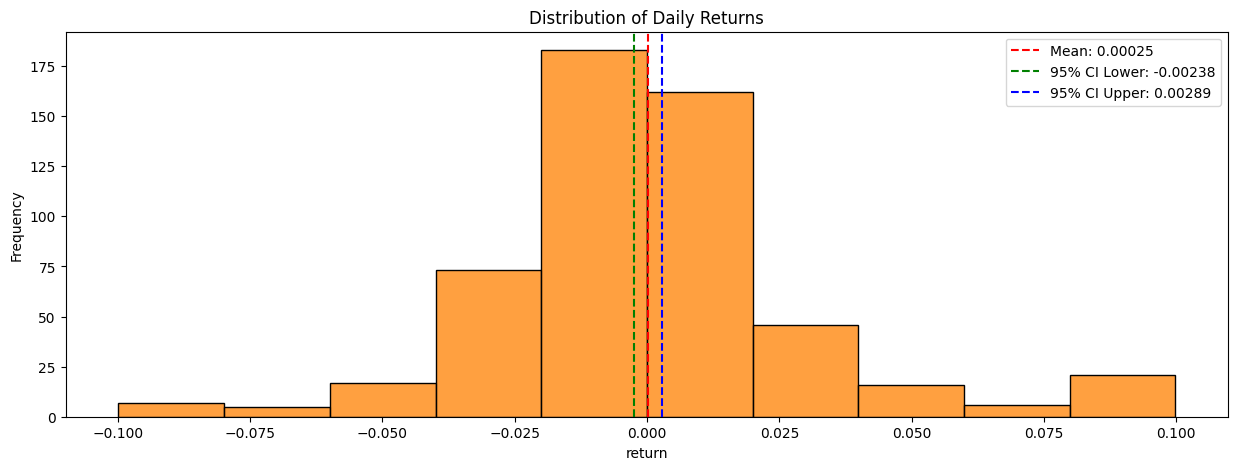

In [93]:
plt.figure(figsize=(15, 5))
sns.histplot(data = stock_df, x = 'return', color= '#FF8000', kde=False, bins=10)
plt.axvline(stock_df_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {round(stock_df_mean, 5)}')
plt.axvline(lower_bound, color='green', linestyle='dashed', linewidth=1.5, label=f'95% CI Lower: {round(lower_bound, 5)}')
plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=1.5, label=f'95% CI Upper: {round(upper_bound, 5)}')
plt.title('Distribution of Daily Returns')
plt.ylabel('Frequency')
plt.legend()


In [94]:
Bull_data.to_csv(f"{stock_no}_Bull_data.csv", index=False, encoding="utf-8")
Bear_data.to_csv(f"{stock_no}_Bear_data.csv", index=False, encoding="utf-8")

In [ ]:
# yfinance沒有夏都
# ticker = '2722.TW'

# shiadu = yf.download(ticker, start='2023-01-01', end='2025-03-31')

# print(shiadu.head())

Failed to get ticker '2722.TW' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['2722.TW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Empty DataFrame
Columns: [(Adj Close, 2722.TW), (Close, 2722.TW), (High, 2722.TW), (Low, 2722.TW), (Open, 2722.TW), (Volume, 2722.TW)]
Index: []


In [27]:
news = pd.read_csv('bda2025_202301-202503_內容數據_新聞.csv')
dcard1 = pd.read_csv('bda2025_202301-202503_討論數據_dcard_1.csv')
dcard2 = pd.read_csv('bda2025_202301-202503_討論數據_dcard_2.csv')
mobile01 = pd.read_csv('bda2025_202301-202503_討論數據_Mobile01.csv')
ptt = pd.read_csv('bda2025_202301-202503_討論數據_PTT.csv')
df = pd.concat([dcard1, dcard2, mobile01, ptt],axis=0).reset_index(drop=True)
df.head(10)

,id,p_type,s_name,s_area_name,post_time,title,author,content,page_url,content_type
0,1672661088773_F02_dcard,forum,Dcard,股票,2023-01-01 10:09:24,#分享 台灣通膨現在才注意台股當沖的人已經來不及,瑪姬愛河（德國人）maggie1984212/M,大家好 我是喜歡台股當沖的德國女孩 今天還看看台灣通膨和貸款利息已經變高囉 領死薪水的人未來...,https://www.dcard.tw/f/stock/p/240901233,main
1,1672661068527_F02_dcard,forum,Dcard,股票,2023-01-01 21:50:43,#分享 【投資懶人包】 | 3分鐘讓你學會如何交易股票，以及如何在股市上長久生存,國立高雄科技大學/M,股票是什麼？股票是一種金融工具，它代表著擁有一家公司的股份，可分為上市，上櫃及興櫃。當你擁有...,https://www.dcard.tw/f/stock/p/240904997,main
2,1672661059754_F02_dcard,forum,Dcard,股票,2023-01-02 00:46:16,#分享 2022-12 對帳單,股市丁丁stock___jj/M,https://i.imgur.com/aWD9mIa.jpg 12月 局勢由多轉空 需要到...,https://www.dcard.tw/f/stock/p/240906276,main
3,1672661038877_F02_dcard,forum,Dcard,股票,2023-01-02 01:15:41,#分享 見習新手的2022成績單,Meowcat14152/F,有鑑於ptt的大神們最近都在年度總結 決定也為自己結算 做一個紀錄與檢討 發dcard的原因...,https://www.dcard.tw/f/stock/p/240906482,main
4,1672660998791_F02_dcard,forum,Dcard,股票,2023-01-02 11:05:54,#新聞 中鋼 11月虧損27億元,國立中央大學/M,中鋼（2002）昨（26）日公告自行結算11月合併營收320億元，單月稅前虧損27.6億元，...,https://www.dcard.tw/f/stock/p/240907891,main
5,1672660988183_F02_dcard,forum,Dcard,股票,2023-01-02 14:59:40,01/02 台股收盤指數,巴菲特 Bot 零號機buffettbot/D,⚙️ 大盤收盤統計 ⚙️ 📌 加權指數 14137.69 / 52.67(0.37%) ...,https://www.dcard.tw/f/stock/p/240909183,main
6,1672660973712_F02_dcard,forum,Dcard,股票,2023-01-02 15:59:44,#分享 2022對帳單分享,James_Tradesjamesliao888/M,邁入2023，操作美股穩定獲利接近3年，有賺有虧，但到了最後就是自己與自己的比賽而已！ 3...,https://www.dcard.tw/f/stock/p/240909575,main
7,1672660962798_F02_dcard,forum,Dcard,股票,2023-01-02 18:21:43,#請益 #問 Firstrade 第一證券下單忘了輸股數,國立臺灣師範大學/F,看網路教學之後逐步操作 但我以為限價設定按下一步才要輸入股數 所以就先按送出 🥲🥲 求問 我...,https://www.dcard.tw/f/stock/p/240910496,main
8,1672660952654_F02_dcard,forum,Dcard,股票,2023-01-02 19:51:25,#請益 回顧2022，一個字代表你的股票投資,股狼球隊—助教femmefatale1517/F,新的一年又來啦！ 助教在此祝大家新年快樂🎆 不管去年過得如何 都把不開心的部分留在2022吧...,https://www.dcard.tw/f/stock/p/240911107,main
9,1672706438960_F02_dcard_T,forum,Dcard,股票,2023-01-02 21:04:03,#分享 本週盤勢紀錄分享,leon_stockmes19791128/M,1/2（一）新年快樂！恭喜大家損益歸0重算囉🤗 排版及內容持續優化中••• 一、本週輪動族...,https://www.dcard.tw/f/stock/p/240911680,main


In [95]:
df.shape

(103368, 10)

In [96]:
df_filtered = df[(df['title'].str.contains("夏都")) | (df['content'].str.contains("聯發科"))]
df_filtered.head(10)

,id,p_type,s_name,s_area_name,post_time,title,author,content,page_url,content_type
138,1673435589760_F02_dcard,forum,Dcard,股票,2023-01-11 17:36:58,#標的 哪檔股票可以讓我存到退休不賠,國立臺中科技大學/M,Option #1: 台積電 Option #2: 鴻海 Option #3: 富邦金 Op...,https://www.dcard.tw/f/stock/p/240982076,main
193,1673619820544_F02_dcard,forum,Dcard,股票,2023-01-13 21:52:03,#請益 靠穩健獲利的股票賺穩定的被動收入實務上是可行的嗎,致理科技大學/M,請問大家 如果買穩健獲利的股票 例如中華電 鴻海 聯發科等 例如買50張中華電或是50張鴻海...,https://www.dcard.tw/f/stock/p/241000149,main
207,1673818280771_F02_dcard,forum,Dcard,股票,2023-01-16 05:18:57,#標的 聯發科,⚖️🔥singhua1635/M,想問問各位大神現在對聯發科的看法,https://www.dcard.tw/f/stock/p/241016575,main
571,1676101172170_F02_dcard,forum,Dcard,股票,2023-02-11 15:20:07,#請益 聯發科股票請益,kaallen_0820/M,本資料由 (上市公司) 聯發科 公司提供 民國112年01月 單位：新台幣仟元 項目 ...,https://www.dcard.tw/f/stock/p/241200725,main
681,1676483773891_F02_dcard,forum,Dcard,股票,2023-02-16 01:43:36,#標的 半導體 - 產業介紹,台股/美股-合理價計算clark198502/M,半導體 - 產業介紹 https://740213f.blogspot.com/searc...,https://www.dcard.tw/f/stock/p/241241470,main
922,1677131337595_F02_dcard,forum,Dcard,股票,2023-02-23 13:46:54,#分享 定期定額（10K/day）紀錄追蹤,進化小資族fohsindating/M,目標設定：透過定期定額自選台股標的的方式，期望中/長（三至五年）期整體績效勝過大盤。 標的...,https://www.dcard.tw/f/stock/p/241310421,main
993,1677378386348_F02_dcard,forum,Dcard,股票,2023-02-26 10:21:33,#分享 1~2月台美股佈局標的,純純存股chunchunloveyou/M,這兩個月依舊照著自己的策略，進行長期佈局 📍台股 0050被動參與市場，持續無腦買 台積...,https://www.dcard.tw/f/stock/p/241336529,main
1035,1677654877829_F02_dcard,forum,Dcard,股票,2023-03-01 14:59:50,03/01 台股收盤指數,巴菲特 Bot 零號機buffettbot/D,⚙️ 大盤收盤統計 ⚙️ 📌 加權指數 15598.49 / 94.7(0.61%) 📌...,https://www.dcard.tw/f/stock/p/241362324,main
1047,1677682832559_F02_dcard,forum,Dcard,股票,2023-03-01 22:34:08,#分享 2023/03/01 股市市場分析,承通投顧win2781/M,【開低走高只漲台積、方向未明等待時機】 投資朋友大家好 我是謝明哲分析師👋🏻 今天台股是...,https://www.dcard.tw/f/stock/p/241366303,main
1049,1677683131527_F02_dcard,forum,Dcard,股票,2023-03-01 22:43:50,#分享 3/1 美股持續走弱，台股獨強的機會並不高,東海彼得a8343656/M,. 雖然今天大陸經濟好轉，加上聯發科發放超高股利，讓電子權值大力反彈，但細心的人會發現今天大...,https://www.dcard.tw/f/stock/p/241366396,main


In [97]:
df_filtered = df_filtered[['post_time','title', 'content']]
df_filtered.shape

(2667, 3)

In [98]:
df_filtered['post_time'] = pd.to_datetime(df_filtered['post_time']).dt.date
df_filtered.head(10)


,post_time,title,content
138,2023-01-11,#標的 哪檔股票可以讓我存到退休不賠,Option #1: 台積電 Option #2: 鴻海 Option #3: 富邦金 Op...
193,2023-01-13,#請益 靠穩健獲利的股票賺穩定的被動收入實務上是可行的嗎,請問大家 如果買穩健獲利的股票 例如中華電 鴻海 聯發科等 例如買50張中華電或是50張鴻海...
207,2023-01-16,#標的 聯發科,想問問各位大神現在對聯發科的看法
571,2023-02-11,#請益 聯發科股票請益,本資料由 (上市公司) 聯發科 公司提供 民國112年01月 單位：新台幣仟元 項目 ...
681,2023-02-16,#標的 半導體 - 產業介紹,半導體 - 產業介紹 https://740213f.blogspot.com/searc...
922,2023-02-23,#分享 定期定額（10K/day）紀錄追蹤,目標設定：透過定期定額自選台股標的的方式，期望中/長（三至五年）期整體績效勝過大盤。 標的...
993,2023-02-26,#分享 1~2月台美股佈局標的,這兩個月依舊照著自己的策略，進行長期佈局 📍台股 0050被動參與市場，持續無腦買 台積...
1035,2023-03-01,03/01 台股收盤指數,⚙️ 大盤收盤統計 ⚙️ 📌 加權指數 15598.49 / 94.7(0.61%) 📌...
1047,2023-03-01,#分享 2023/03/01 股市市場分析,【開低走高只漲台積、方向未明等待時機】 投資朋友大家好 我是謝明哲分析師👋🏻 今天台股是...
1049,2023-03-01,#分享 3/1 美股持續走弱，台股獨強的機會並不高,. 雖然今天大陸經濟好轉，加上聯發科發放超高股利，讓電子權值大力反彈，但細心的人會發現今天大...


In [99]:
df_filtered

,post_time,title,content
138,2023-01-11,#標的 哪檔股票可以讓我存到退休不賠,Option #1: 台積電 Option #2: 鴻海 Option #3: 富邦金 Op...
193,2023-01-13,#請益 靠穩健獲利的股票賺穩定的被動收入實務上是可行的嗎,請問大家 如果買穩健獲利的股票 例如中華電 鴻海 聯發科等 例如買50張中華電或是50張鴻海...
207,2023-01-16,#標的 聯發科,想問問各位大神現在對聯發科的看法
571,2023-02-11,#請益 聯發科股票請益,本資料由 (上市公司) 聯發科 公司提供 民國112年01月 單位：新台幣仟元 項目 ...
681,2023-02-16,#標的 半導體 - 產業介紹,半導體 - 產業介紹 https://740213f.blogspot.com/searc...
...,...,...,...
103167,2025-02-26,[情報] 0226 上市外資買賣超排行,1. 標題：外資買賣超排行 2. 來源：台灣證交所 3. 網址：https://www....
103194,2025-02-26,[情報] 0226 上市櫃外資投信買超金額排行,外資 排行 股票名稱 收盤價 漲跌 買超(百萬) 1 245...
103241,2025-02-27,[閒聊] 2025/02/27 盤後閒聊,台 股 23053.18 ▼349.37 (-1.49%) 5229.64億 台指03 23...
103248,2025-02-27,[情報] 0227 上市投信買賣超排行,1. 標題：投信買賣超排行 2. 來源：富邦證券 3. 網址：https://tinyu...


In [101]:
df_filtered.to_csv(f"{stock_no}_news.csv", index=False, encoding="utf-8")

In [103]:
import csv
import monpa
from monpa import utils

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


In [ ]:
#篩選出顯示牛市或熊市的新聞
df_filtered['post_time'] = pd.to_datetime(df_filtered['post_time']).dt.date
Bull_data['previous_date_2'] = pd.to_datetime(Bull_data['previous_date_2']).dt.date
Bear_data['previous_date_2'] = pd.to_datetime(Bear_data['previous_date_2']).dt.date


Bull_news = df_filtered[df_filtered['post_time'].isin(Bull_data['previous_date_2'])]
Bear_news = df_filtered[df_filtered['post_time'].isin(Bear_data['previous_date_2'])]
Bull_news['BullBear'] = 1
Bear_news['BullBear'] = -1
Bull_news

/var/folders/dp/v8nwqctd0rqfmk1cclf4q0w40000gn/T/ipykernel_19173/1833469054.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bull_news['BullBear'] = 1
/var/folders/dp/v8nwqctd0rqfmk1cclf4q0w40000gn/T/ipykernel_19173/1833469054.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bear_news['BullBear'] = -1


,post_time,title,content,BullBear
207,2023-01-16,#標的 聯發科,想問問各位大神現在對聯發科的看法,1
681,2023-02-16,#標的 半導體 - 產業介紹,半導體 - 產業介紹 https://740213f.blogspot.com/searc...,1
922,2023-02-23,#分享 定期定額（10K/day）紀錄追蹤,目標設定：透過定期定額自選台股標的的方式，期望中/長（三至五年）期整體績效勝過大盤。 標的...,1
1035,2023-03-01,03/01 台股收盤指數,⚙️ 大盤收盤統計 ⚙️ 📌 加權指數 15598.49 / 94.7(0.61%) 📌...,1
1047,2023-03-01,#分享 2023/03/01 股市市場分析,【開低走高只漲台積、方向未明等待時機】 投資朋友大家好 我是謝明哲分析師👋🏻 今天台股是...,1
...,...,...,...,...
102509,2025-02-18,[新聞] 英特爾晶圓代工另一生機 加速拉攏聯家,原文標題：英特爾晶圓代工另一生機 加速拉攏聯家軍、二線廠 原文連結： https:/...,1
102531,2025-02-18,[閒聊] 2025/02/18 盤後閒聊,台 股 23666.11 ▲160.78 (+0.68%) 3307.85億 台指02 23...,1
102538,2025-02-18,[情報] 0218 上市投信買賣超排行,1. 標題：投信買賣超排行 2. 來源：富邦證券 3. 網址：https://tinyu...,1
102555,2025-02-18,[新聞] 英特爾美股夜盤漲超5% 消息稱台積電或收購,原文標題： 英特爾美股夜盤漲超5% 消息稱台積電或收購其代工部門20%股權 原文連結： ...,1


In [110]:
Bear_news

,post_time,title,content,BullBear
1409,2023-03-12,#請益 聯發科769,聯發科成本769請問有救嗎 明天因為矽谷的關係應該也會一路跌 要繼續攤平還是止損 https...,-1
1501,2023-03-14,#標的 低軌衛星 - 產業介紹,低軌衛星 - 產業介紹 https://740213f.blogspot.com/sear...,-1
1763,2023-03-22,#分享 26檔股一桶金10年回測（影片）,新增14檔 0050 0056 中信金 中租 中華電 中鋼 仁寶 兆豐金 光寶科 凱撒衛 台...,-1
1981,2023-03-29,#分享 2022年個股觀念與想法,台灣船PE狀況就像美股之前美鋼 PE殺過頭 春節後補漲 妖股拉不動 就要小心了 目前看起來...,-1
1997,2023-03-29,#分享 定期定額（10K/day) 選股邏輯,上篇至今已經過了一個多月，結果現在才有時間分享這八檔股票的選取邏輯（反正沒什麼人看就拖延一下...,-1
...,...,...,...,...
103113,2025-02-26,[情報] 0225 上市櫃外資投信買超金額排行,外資 排行 股票名稱 收盤價 漲跌 買超(百萬) 1 202...,-1
103150,2025-02-26,[閒聊] 2025/02/26 盤後閒聊,台 股 23402.55 ▲116.83 (+0.50%) 3683.61億 台指03 23...,-1
103158,2025-02-26,[情報] 0226 上市投信買賣超排行,1. 標題：投信買賣超排行 2. 來源：富邦證券 3. 網址：https://tinyu...,-1
103167,2025-02-26,[情報] 0226 上市外資買賣超排行,1. 標題：外資買賣超排行 2. 來源：台灣證交所 3. 網址：https://www....,-1


In [111]:
Bull_news.to_csv(f"{stock_no}_Bull_news.csv", index=False, encoding="utf-8")
Bear_news.to_csv(f"{stock_no}_Bear_news.csv", index=False, encoding="utf-8")